# Import Library

In [2]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Conv2D, MaxPool2D, Flatten
from keras.utils import to_categorical
from keras.models import load_model

# Model CNN

## 1. Read image & Covert

In [3]:
def detect_face(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [4]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label: %s \t\t" % (progr, val+1, folder), end="\r")

In [5]:
dataset_folder = "dataset/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    # print(folder)
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    # print(files)
    if len(files) < 50:
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img) # detect face using mtcnn and crop to 100x100
            if img is not None :
                images.append(img)
                names.append(folder)
                
                print_progress(i, len(files), folder)


[####################] (77 samples)	 label: Ariel_Sharon 		
[####################] (150 samples)	 label: Colin_Powell 		
[####################] (121 samples)	 label: Donald_Rumsfeld 		
[####################] (150 samples)	 label: George_W_Bush 		
[####################] (109 samples)	 label: Gerhard_Schroeder 		
[####################] (71 samples)	 label: Hugo_Chavez 		
[####################] (52 samples)	 label: Jacques_Chirac 		
[####################] (55 samples)	 label: Jean_Chretien 		
[####################] (53 samples)	 label: John_Ashcroft 		
[####################] (60 samples)	 label: Junichiro_Koizumi 		
[####################] (52 samples)	 label: Serena_Williams 		
[####################] (101 samples)	 label: Thinh_Ngo 		


In [6]:
print("number of samples :", len(names))

number of samples : 1195


### 1.1. Image Augmentation

In [7]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

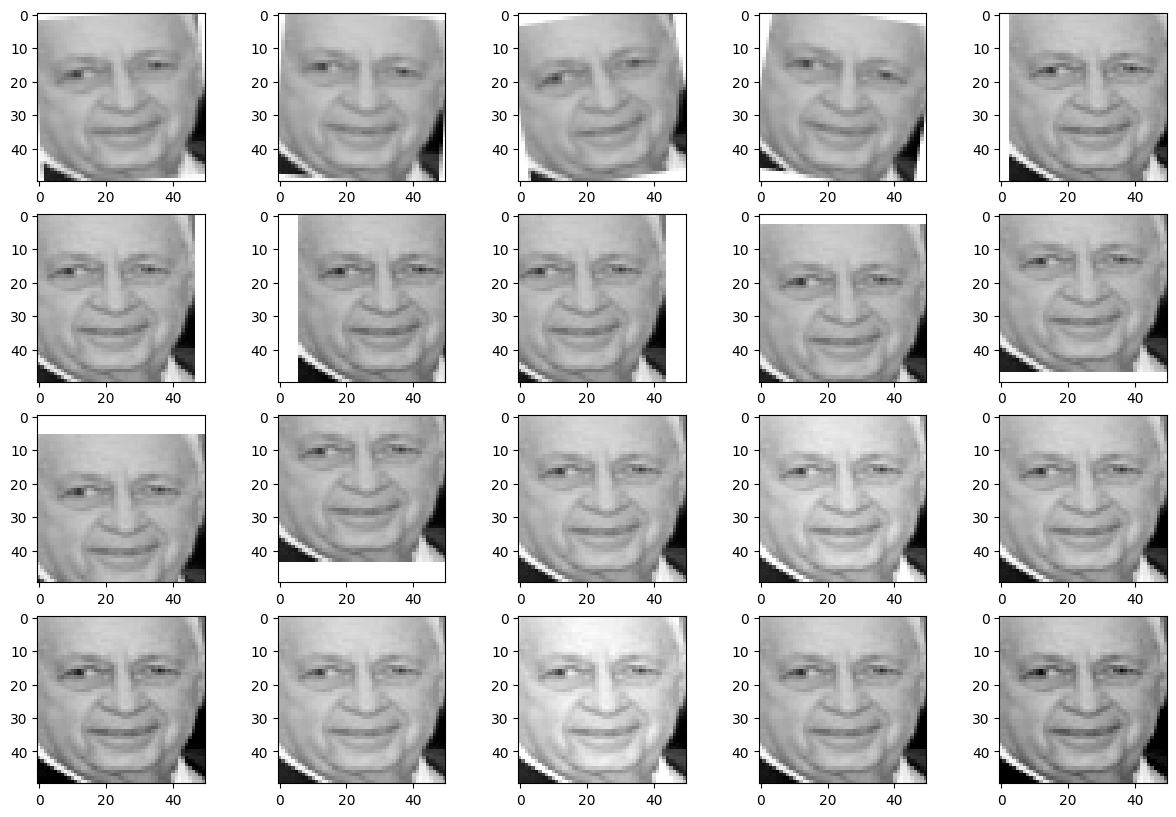

In [8]:
img_test = images[0]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [9]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

In [10]:
len(augmented_images), len(augmented_names)

(23900, 23900)

In [11]:
images.extend(augmented_images)
names.extend(augmented_names)

In [12]:
len(images), len(names)

(25095, 25095)

In [13]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Ariel_Sharon', 1617)
('Colin_Powell', 3150)
('Donald_Rumsfeld', 2541)
('George_W_Bush', 3150)
('Gerhard_Schroeder', 2289)
('Hugo_Chavez', 1491)
('Jacques_Chirac', 1092)
('Jean_Chretien', 1155)
('John_Ashcroft', 1113)
('Junichiro_Koizumi', 1260)
('Serena_Williams', 1092)
('Thinh_Ngo', 2121)
('Tony_Blair', 3024)


### 1.2. Balancing Data

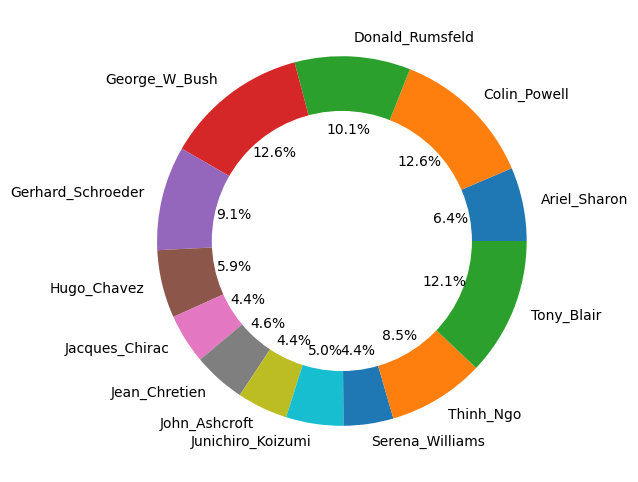

In [14]:
def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [15]:
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [16]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

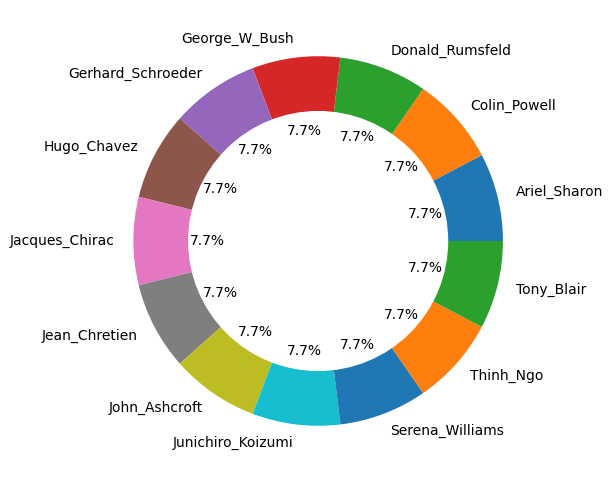

In [17]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

## 2. Encoding Label

In [18]:
le = LabelEncoder()
le.fit(names)
labels = le.classes_
name_vec = le.transform(names)
categorical_name_vec = to_categorical(name_vec)

In [19]:
print("number of class :", len(labels))
print(labels)

number of class : 13
['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Jacques_Chirac' 'Jean_Chretien'
 'John_Ashcroft' 'Junichiro_Koizumi' 'Serena_Williams' 'Thinh_Ngo'
 'Tony_Blair']


In [20]:
print(name_vec)

[ 0  0  0 ... 12 12 12]


In [21]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## 3. Split Dataset

In [22]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [23]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(11050, 50, 50) (11050, 13) (1950, 50, 50) (1950, 13)


In [24]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [25]:
x_train.shape, x_test.shape

((11050, 50, 50, 1), (1950, 50, 50, 1))

## 4. Create Model

In [26]:
def cnn_model(input_shape):  
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))  # equal to number of classes
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

## 5. Training Model

In [27]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                    

In [29]:
from keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


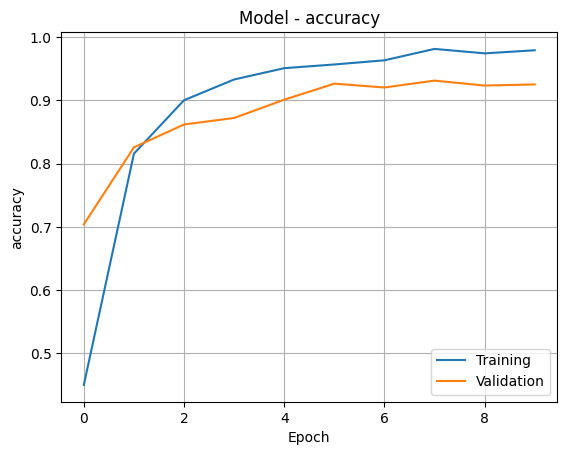

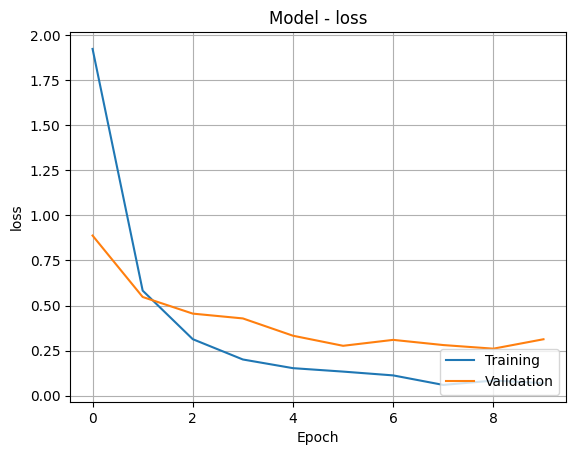

In [28]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()
        
evaluate_model_(history)

In [30]:
model.save("model.h5")

In [31]:
y_pred=model.predict(x_test)

61/61 [==============================] - 19s 166ms/step


In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

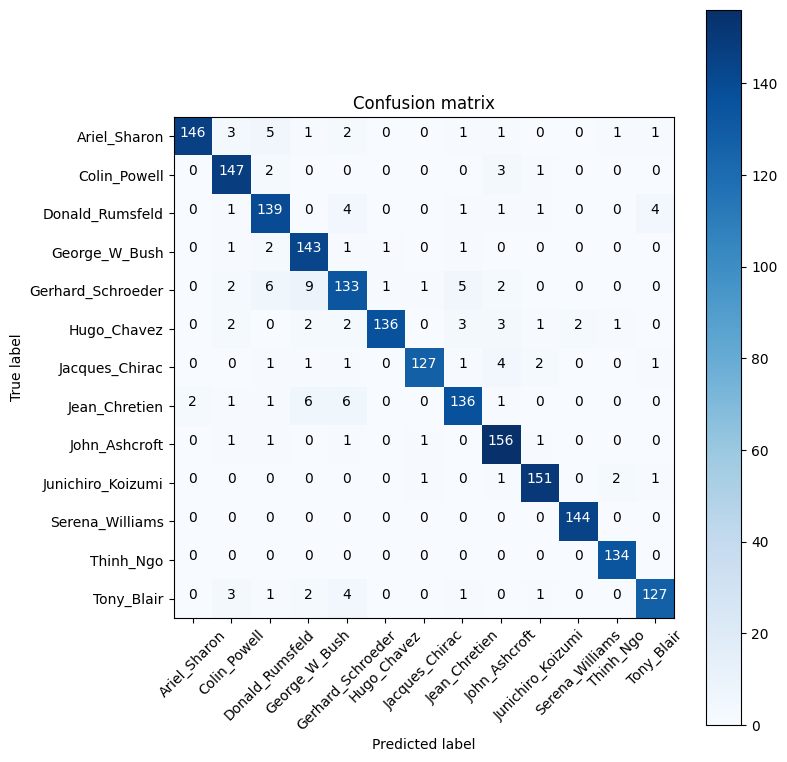

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')


In [34]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.99      0.91      0.94       161
     Colin_Powell       0.91      0.96      0.94       153
  Donald_Rumsfeld       0.88      0.92      0.90       151
    George_W_Bush       0.87      0.96      0.91       149
Gerhard_Schroeder       0.86      0.84      0.85       159
      Hugo_Chavez       0.99      0.89      0.94       152
   Jacques_Chirac       0.98      0.92      0.95       138
    Jean_Chretien       0.91      0.89      0.90       153
    John_Ashcroft       0.91      0.97      0.94       161
Junichiro_Koizumi       0.96      0.97      0.96       156
  Serena_Williams       0.99      1.00      0.99       144
        Thinh_Ngo       0.97      1.00      0.99       134
       Tony_Blair       0.95      0.91      0.93       139

         accuracy                           0.93      1950
        macro avg       0.94      0.93      0.93      1950
     weighted avg       0.93      0.93      0.93      

# Face Recognition using VideoCam

In [28]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    # Rectangle face
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    # Rectangle name
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [29]:
# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

# --------- load Keras CNN model -------------
model = load_model("model.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 90:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
1/1 [==============================] - 1s 517ms/step
